VAE TESTING

In [ ]:

from __future__ import absolute_import, division
from __future__ import print_function

MNIST Data

Source https://github.com/HIPS/autograd/blob/master/examples/data_mnist.py

In [ ]:
#from __future__ import absolute_import
#from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()

import os
import gzip
import struct
import array
import numpy as np
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels

Source: https://github.com/HIPS/autograd/blob/master/examples/data.py

In [ ]:
#from __future__ import absolute_import
import matplotlib.pyplot as plt
import matplotlib.image

import autograd.numpy as np
import autograd.numpy.random as npr
#import data_mnist

def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    #train_images, train_labels, test_images, test_labels = data_mnist.mnist()
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = (N_images - 1) // ims_per_row + 1
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
    cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    return cax

def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)


def make_pinwheel(radial_std, tangential_std, num_classes, num_per_class, rate,
                  rs=npr.RandomState(0)):
    """Based on code by Ryan P. Adams."""
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = rs.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:, 0] += 1
    labels = np.repeat(np.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return np.einsum('ti,tij->tj', features, rotations)


# VAE

Define and test out a VAE

Source https://github.com/HIPS/autograd/blob/master/examples/variational_autoencoder.py

Loading training data...
Binarising training data...
     Epoch     |    Objective       |    Test ELBO  
              0|  0.6932584206858606|  0.6932658793488439
              0|  0.6842849129464189|
              0|  0.6452992015955531|
              0|  0.5321971419593212|
              0| 0.40756819418767254|
              0|  0.3228370999978949|
              0|  0.2811445004050572|
              0|  0.2974902286890794|
              0|  0.2605104243037134|
              0|   0.247576301366411|
              0|  0.2705762342910167|  0.2544951504447709
              0|   0.273363533743689|
              0| 0.23792007931717812|
              0| 0.24117258074155562|
              0| 0.24310971905297266|
              0| 0.25596724480141814|
              0| 0.24410074875637935|
              0| 0.23731461494549388|
              0|  0.2419736876383133|
              0| 0.23539889313327136|
              0| 0.23150711444336194| 0.23249634347554238
              0|  0.2264712342246887

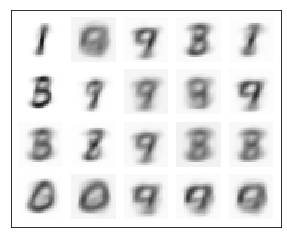

In [ ]:
# Implements auto-encoding variational Bayes.

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd.scipy.special import expit as sigmoid

from autograd import grad
from autograd.misc.optimizers import adam
#from data import load_mnist, save_images

def diag_gaussian_log_density(x, mu, log_std):
    return np.sum(norm.logpdf(x, mu, np.exp(log_std)), axis=-1) # https://stackoverflow.com/questions/43602270/what-is-probability-density-function-in-the-context-of-scipy-stats-norm

def unpack_gaussian_params(params):
    # Params of a diagonal Gaussian.
    D = np.shape(params)[-1] // 2
    mean, log_std = params[:, :D], params[:, D:]
    return mean, log_std

def sample_diag_gaussian(mean, log_std, rs):
    return rs.randn(*mean.shape) * np.exp(log_std) + mean

def bernoulli_log_density(targets, unnormalized_logprobs):
    # unnormalized_logprobs are in R
    # Targets must be -1 or 1
    label_probabilities = -np.logaddexp(0, -unnormalized_logprobs*targets)  # Logarithm of exp(x1) + exp(x2), works out to the logistic formula
    return np.sum(label_probabilities, axis=-1)   # Sum across pixels.

def relu(x):    return np.maximum(0, x)

def init_net_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a (weights, biases) tuples for all layers."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def neural_net_predict(params, inputs):
    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       Applies batch normalization to every layer but the last."""
    for W, b in params[:-1]:
        outputs = batch_normalize(np.dot(inputs, W) + b)  # linear transformation
        inputs = relu(outputs)                            # nonlinear transformation
    outW, outb = params[-1]
    outputs = np.dot(inputs, outW) + outb
    return outputs

def nn_predict_gaussian(params, inputs):
    # Returns means and diagonal variances
    return unpack_gaussian_params(neural_net_predict(params, inputs))

def generate_from_prior(gen_params, num_samples, noise_dim, rs):
    latents = rs.randn(num_samples, noise_dim)
    return sigmoid(neural_net_predict(gen_params, latents))

def p_images_given_latents(gen_params, images, latents):
    preds = neural_net_predict(gen_params, latents)
    return bernoulli_log_density(images, preds)

def vae_lower_bound(gen_params, rec_params, data, rs):
    # We use a simple Monte Carlo estimate of the KL
    # divergence from the prior.
    q_means, q_log_stds = nn_predict_gaussian(rec_params, data)
    latents = sample_diag_gaussian(q_means, q_log_stds, rs)
    q_latents = diag_gaussian_log_density(latents, q_means, q_log_stds)
    p_latents = diag_gaussian_log_density(latents, 0, 0) # standard normal prior
    likelihood = p_images_given_latents(gen_params, data, latents)
    return np.mean(p_latents + likelihood - q_latents) #elbow



# ---------------------


# Model hyper-parameters
latent_dim = 10
data_dim = 784  # How many pixels in each image (28x28).
gen_layer_sizes = [latent_dim, 300, 200, data_dim] # latent, hidden_3, hidden_4, output
rec_layer_sizes = [data_dim, 200, 300, latent_dim * 2] # input, hidden_1, hidden_2, latent (mu and sigma)

# Training parameters
param_scale = 0.01
batch_size = 200
#num_epochs = 15
num_epochs = 1
step_size = 0.001

print("Loading training data...")
N, train_images, _, test_images, _ = load_mnist()
# -1 or 1 ?
def binarise(images):
    on = images > 0.5
    images = images * 0 - 1
    images[on] = 1.0
    return images

print("Binarising training data...")
train_images = binarise(train_images)
test_images = binarise(test_images)

init_gen_params = init_net_params(param_scale, gen_layer_sizes)
init_rec_params = init_net_params(param_scale, rec_layer_sizes)
combined_init_params = (init_gen_params, init_rec_params)

num_batches = int(np.ceil(len(train_images) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

# Define training objective
seed = npr.RandomState(0)
def objective(combined_params, iter):
    data_idx = batch_indices(iter)
    gen_params, rec_params = combined_params
    return -vae_lower_bound(gen_params, rec_params, train_images[data_idx], seed) / data_dim

# Get gradients of objective using autograd.
objective_grad = grad(objective)

print("     Epoch     |    Objective       |    Test ELBO  ")
def print_perf(combined_params, iter, grad):
    if iter % 10 == 0:
        gen_params, rec_params = combined_params
        bound = np.mean(objective(combined_params, iter))
        message = "{:15}|{:20}|".format(iter//num_batches, bound)
        if iter % 100 == 0:
            test_bound = -vae_lower_bound(gen_params, rec_params, test_images, seed) / data_dim
            message += "{:20}".format(test_bound)
        print(message)

        fake_data = generate_from_prior(gen_params, 20, latent_dim, seed)
        save_images(fake_data, 'vae_samples.png', vmin=0, vmax=1)

# The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params = adam(objective_grad, combined_init_params, step_size=step_size,
                        num_iters=num_epochs * num_batches, callback=print_perf)

# BNN

https://github.com/HIPS/autograd/blob/master/examples/bayesian_neural_net.py

https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py

In [ ]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.misc.optimizers import adam


def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr

#from black_box_svi import black_box_variational_inference
from autograd.misc.optimizers import adam


def make_nn_funs(layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = sum((m+1)*n for m, n in shapes)

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs

    def logprob(weights, inputs, targets):
        log_prior = -L2_reg * np.sum(weights**2, axis=1)
        preds = predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2, axis=1)[:, 0] / noise_variance
        return log_prior + log_lik

    return num_weights, predictions, logprob


def build_toy_dataset(n_data=40, noise_std=0.1):
    D = 1
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 2, num=n_data//2),
                              np.linspace(6, 8, num=n_data//2)])
    targets = np.cos(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 4.0
    inputs  = inputs.reshape((len(inputs), D))
    targets = targets.reshape((len(targets), D))
    return inputs, targets


# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: np.exp(-x**2)
relu = lambda x: np.maximum(x, 0.)
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[1, 20, 20, 1], L2_reg=0.1,
                  noise_variance=0.01, nonlinearity=rbf)

inputs, targets = build_toy_dataset()
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_posterior, num_weights,
                                    num_samples=20)

# Set up figure.
'''
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)
'''


def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

    # Sample functions from posterior.
    rs = npr.RandomState(0)
    mean, log_std = unpack_params(params)
    #rs = npr.RandomState(0)
    sample_weights = rs.randn(10, num_weights) * np.exp(log_std) + mean
    plot_inputs = np.linspace(-8, 8, num=400)
    outputs = predictions(sample_weights, np.expand_dims(plot_inputs, 1))

    # Plot data and functions.
    '''
    plt.cla()
    ax.plot(inputs.ravel(), targets.ravel(), 'bx')
    ax.plot(plot_inputs, outputs[:, :, 0].T)
    ax.set_ylim([-2, 3])
    plt.draw()
    plt.pause(1.0/60.0)
    '''

# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -5 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

print("Optimizing variational parameters...")
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=1000, callback=callback)

Optimizing variational parameters...
Iteration 0 lower bound -11682.108060097273
Iteration 1 lower bound -8370.240441279715
Iteration 2 lower bound -4289.866187182439
Iteration 3 lower bound -2469.3231150302317
Iteration 4 lower bound -2331.5858920779633
Iteration 5 lower bound -2394.769123796193
Iteration 6 lower bound -2141.89016137708
Iteration 7 lower bound -1937.5602411468362
Iteration 8 lower bound -1834.4289964833297
Iteration 9 lower bound -1715.5397033698605
Iteration 10 lower bound -1617.0839382051636
Iteration 11 lower bound -1687.452288928266
Iteration 12 lower bound -1684.36164085515
Iteration 13 lower bound -1615.6742108756744
Iteration 14 lower bound -1486.5357137627225
Iteration 15 lower bound -1424.2902985703417
Iteration 16 lower bound -1373.926791874661
Iteration 17 lower bound -1268.6318970168902
Iteration 18 lower bound -1224.5002955852808
Iteration 19 lower bound -1155.3426562622176
Iteration 20 lower bound -1130.1205724709348
Iteration 21 lower bound -1086.737478

# Conditional VAE

Loading training data...
Binarising training data...
     Epoch     |    Objective       |    Test ELBO  
              0|  0.6931072510892908|   0.693115652839441
              0|  0.6841927304550305|
              0|  0.6463121278821488|
              0|  0.5335755386414979|
              0| 0.40329663028977436|
              0|  0.3134582342048598|
              0|  0.2791614755544154|
              0|  0.2938607796027756|
              0|  0.2594956284146887|
              0| 0.24165886904691442|
              0| 0.26709156981207677|  0.2489107648303926
              0| 0.26893226269126247|
              0| 0.22794042495578723|
              0| 0.23276435929256725|
              0| 0.23591749115028962|
              0|  0.2538492745088375|
              0| 0.23973593272618118|
              0|  0.2371972232456379|
              0| 0.23945464261169733|
              0| 0.23088238458090768|
              0|  0.2277669700223499| 0.23004269612949443
              0| 0.22636297992421356

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

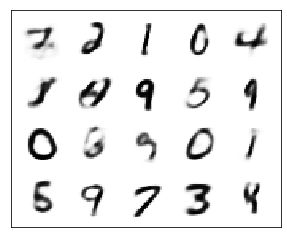

In [ ]:

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd.scipy.special import expit as sigmoid

from autograd import grad
from autograd.misc.optimizers import adam
#from data import load_mnist, save_images

def diag_gaussian_log_density(x, mu, log_std):
    return np.sum(norm.logpdf(x, mu, np.exp(log_std)), axis=-1) # https://stackoverflow.com/questions/43602270/what-is-probability-density-function-in-the-context-of-scipy-stats-norm

def unpack_gaussian_params(params):
    # Params of a diagonal Gaussian.
    D = np.shape(params)[-1] // 2
    mean, log_std = params[:, :D], params[:, D:]
    return mean, log_std

def sample_diag_gaussian(mean, log_std, rs):
    return rs.randn(*mean.shape) * np.exp(log_std) + mean

def bernoulli_log_density(targets, unnormalized_logprobs):
    # unnormalized_logprobs are in R
    # Targets must be -1 or 1
    label_probabilities = -np.logaddexp(0, -unnormalized_logprobs*targets)  # Logarithm of exp(x1) + exp(x2), works out to the logistic formula
    return np.sum(label_probabilities, axis=-1)   # Sum across pixels.

def relu(x):    return np.maximum(0, x)

def init_net_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a (weights, biases) tuples for all layers."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def neural_net_predict(params, inputs, labels):
    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       Applies batch normalization to every layer but the last."""
    for i, (W, b) in enumerate(params[:-1]):
        #print(f'inputs:{inputs.shape}')
        #print(f'labels:{labels.shape}')
        if i == 0:
          inputs = np.concatenate((inputs, labels), axis=1)
        outputs = batch_normalize(np.dot(inputs, W) + b)  # linear transformation
        inputs = relu(outputs)                            # nonlinear transformation
    outW, outb = params[-1]
    outputs = np.dot(inputs, outW) + outb
    return outputs

def nn_predict_gaussian(params, inputs, labels):
    # Returns means and diagonal variances
    return unpack_gaussian_params(neural_net_predict(params, inputs, labels))

def generate_from_prior(gen_params, num_samples, noise_dim, labels, rs):
    latents = rs.randn(num_samples, noise_dim)
    return sigmoid(neural_net_predict(gen_params, latents, labels))

def p_images_given_latents(gen_params, images, labels, latents):
    preds = neural_net_predict(gen_params, latents, labels)
    return bernoulli_log_density(images, preds)

def vae_lower_bound(gen_params, rec_params, data, labels, rs):
    # We use a simple Monte Carlo estimate of the KL
    # divergence from the prior.
    q_means, q_log_stds = nn_predict_gaussian(rec_params, data, labels)
    latents = sample_diag_gaussian(q_means, q_log_stds, rs)
    q_latents = diag_gaussian_log_density(latents, q_means, q_log_stds)
    p_latents = diag_gaussian_log_density(latents, 0, 0) # standard normal prior
    likelihood = p_images_given_latents(gen_params, data, labels, latents)
    return np.mean(p_latents + likelihood - q_latents) #elbow


# ---------------------


# Model hyper-parameters
latent_dim = 10
data_dim = 784  # How many pixels in each image (28x28).
cond_dim = 10 # conditioning dimension (1 hot vector)

gen_layer_sizes = [latent_dim + cond_dim, 300, 200, data_dim] # latent, hidden_3, hidden_4, output
rec_layer_sizes = [data_dim + cond_dim, 200, 300, latent_dim * 2] # input, hidden_1, hidden_2, latent (mu and sigma)

# Training parameters
param_scale = 0.01
batch_size = 200
#num_epochs = 15
num_epochs = 20
step_size = 0.001

print("Loading training data...")
N, train_images, train_labels, test_images, test_labels = load_mnist()
# -1 or 1 ?
def binarise(images):
    on = images > 0.5
    images = images * 0 - 1
    images[on] = 1.0
    return images

print("Binarising training data...")
train_images = binarise(train_images)
test_images = binarise(test_images)

#print(f'train_images shape:{train_images.shape}')
#print(f'test_images shape:{test_images.shape}')

#print(f'train_labels shape:{train_labels.shape}')
#print(f'test_labels shape:{test_labels.shape}')

init_gen_params = init_net_params(param_scale, gen_layer_sizes)
init_rec_params = init_net_params(param_scale, rec_layer_sizes)
combined_init_params = (init_gen_params, init_rec_params)

num_batches = int(np.ceil(len(train_images) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx + 1) * batch_size)

# Define training objective
seed = npr.RandomState(0)
def objective(combined_params, iter):
    data_idx = batch_indices(iter)
    gen_params, rec_params = combined_params
    return -vae_lower_bound(gen_params, rec_params, train_images[data_idx],
                            train_labels[data_idx], seed) / data_dim

# Get gradients of objective using autograd.
objective_grad = grad(objective)

print("     Epoch     |    Objective       |    Test ELBO  ")
def print_perf(combined_params, iter, grad):
    if iter % 10 == 0:
        gen_params, rec_params = combined_params
        bound = np.mean(objective(combined_params, iter))
        message = "{:15}|{:20}|".format(iter//num_batches, bound)
        if iter % 100 == 0:
            test_bound = -vae_lower_bound(gen_params, rec_params, test_images,
                                          test_labels, seed) / data_dim
            message += "{:20}".format(test_bound)
        print(message)

        fake_data = generate_from_prior(gen_params, 20, latent_dim, test_labels[:20],seed)
        save_images(fake_data, 'vae_samples.png', vmin=0, vmax=1)

# The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params = adam(objective_grad, combined_init_params, step_size=step_size,
                        num_iters=num_epochs * num_batches, callback=print_perf)

np.argmax(test_labels[:20], axis=1)

In [ ]:
np.argmax(test_labels[:20], axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

Implement VAEAC

Reference - https://github.com/tigvarts/vaeac

https://github.com/asahi417/ConditionalVariationalAutoEncoder/blob/master/model/cvae_cnn2.py

https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

# VAEAC

In [ ]:
# source: https://github.com/azraelzhor/tf2-VAEAC
class MixtureMaskGenerator:

  def __init__(self, generators, weights):
    self.generators = generators
    self.weights = weights

  def __call__(self, inputs):
    w = np.array(self.weights, dtype='float')
    w /= w.sum()
    c_ids = np.random.choice(w.size, inputs.shape[0], True, w)
    mask = np.zeros_like(inputs)

    for i, gen in enumerate(self.generators):
      ids = np.where(c_ids == i)[0]
      if len(ids) == 0:
        continue
      samples = gen(tf.gather(inputs, ids, axis=0))
      mask[ids] = samples
    return mask

VAEAC TF2 Implementation Reference: https://github.com/azraelzhor/tf2-VAEAC

fc_gauss.py reference - https://drive.google.com/drive/folders/1nxU0G3blygdlwuMJ6nddVq207hWzn71l

VAEAC Paper - https://arxiv.org/pdf/1806.02382.pdf

CLUE Paper - https://arxiv.org/pdf/2006.06848.pdf

training - https://colab.research.google.com/drive/1UGkyJR49QzAjsSUZzOsoqdSoxKR9PwL8

VAEAC models conditional distribution over targets given inputs, $p_{gt}(y|x)$. why do we need arbitrary conditioning when we have specific targets $y$?

Role:

- Produce ground truth data to train VAE and BNN
- Provide input to VAE and BNN during counterfactual generation
- Use  $p_{gt}(y|x_c)$ in both aleotoric and epistemic uncertainty calculations
- Assess the relevance of counterfactuals through their likelihood under the g.t. VAEAC $log(p_{gt}(x_c))$

In [ ]:
# 


In [17]:

# from models import prior_network, proposal_network, generative_network

class VAEAC:

    def __init__(self, config):

        # networks
        self.prior_net = prior_network
        self.proposal_net = proposal_network
        self.generative_net = generative_network
        self.config = config #optimizer, epochs etc


    # mask to generate arbitrary conditions
    @staticmethod
    def generate_mask(x):
        return 



    @staticmethod
    def apply_mask(x, mask):
      # input with mask applied
      return



    def prior_distribution(self, x, mask):
      # apply masks to input

      # pass input through prior network to generate mu and sigma

      # produce normal distribution with mu and sigma
      return



    def prior_regularize(self, prior):
        '''
        the parameters of the prior distribution of z may tend
        to infinity, since there is no penalty for large values of those parameters
        '''
        # return mu_regularizer and sigma_regularizer to be added to the model log-likelihood
        return



    def proposal_distribution(self, x):
      # need masks as input??

      # pass input through proposal (posterior) network to generate mu and sigma

      # produce normal distributions with mus and sigmas
      return



    def generative_network_params(self, z_sample):
        g_params = self.generative_network(z_sample)
        return g_params



    def generatve_distribution(self, z_sample):
        g_params = generative_network_params(self, z_sample)
        return g_params



    def compute_loss(self, inputs, masks):

      # Prior distribution ---------------------------------

      # get prior distribution (Gaussian)
      prior_dist = prior_distribution(self, x, mask)

      # prior regularization to be added to the model log-likelihood
      prior_regularization = None # prior_regularization = self.prior_regularizer(prior_dist)


      # Proposal distribution ------------------------------

      # get proposal distribution (Gaussian) TODO - requires mask inputs?
      proposal_dist = proposal_distribution(self, x)

      # sample latents from proposal_dist
      latent = None


      # Generative distribution ----------------------------

      generative_params = self.generative_net(latent)



      # calculate loglikelihood of output of generative distribution out
      loglike = None
      
      # calculate KL divergence
      kl = None # kl_divergence(proposal_distribution, prior_distribution)
        
      return loglike - kl + prior_regularization


      

      def fit(self):


        for epoch in range(1, self.config.epochs + 1):

          # generate masks for data set

          # compute gradiates of loss function

        return




    '''
    def elbo(self, prior, approx_post, x, rec_params):
        # calculate log likelihood

        # calculate KL divergence
        # kl = kl_divergence(approx_post, prior)
        
        # calculate prior_regularization

        return # loglike - kl + prior_regularization

    def iwlb(self, prior, approx_post, x, n=100):
      # Importance Weighted Lower Bound 
      estimates = []
        for i in range(n):

          # TODO reparameterize
          # sample from latent space

          # calculate sum of log_prior of latents

          # calculate sum of log_posterior of latents

          # generate mu and sigma from generative network

          # calculate log likelihood of the model

          # est = rec_loglike + prior_log_prob - proposal_log_prob
          # estimates.append(est)

        return #logsumexp of estimates - np.log(n) ???

          

    
        return



    
    def fit(self, x):

        approx_post = self.proposal_distribution(x)

        #sample from posterior
        z_sample = None

        rec_params = self.generator_params(z_sample)

        # calculate loss on ELBO

        return
    '''

    


      
#objective_grad = grad(objective)



Prior Network

Proposal (posterior Network)

input: 

Generator network